In [1]:
trial_number_ml = "005"
random_state_init = 555

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 16:20:04,114] A new study created in memory with name: no-name-d15acd46-cfb2-44dc-9dc9-221b0830c856


[I 2024-05-01 16:20:46,166] Trial 2 finished with value: 0.7309501315535509 and parameters: {'n_estimators': 201, 'max_depth': 68, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7309501315535509.


[I 2024-05-01 16:21:27,809] Trial 4 finished with value: 0.7217078596897571 and parameters: {'n_estimators': 277, 'max_depth': 93, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.7309501315535509.


[I 2024-05-01 16:21:32,632] Trial 1 finished with value: 0.7315875821574783 and parameters: {'n_estimators': 532, 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.7315875821574783.


[I 2024-05-01 16:22:02,994] Trial 0 finished with value: 0.729994209612044 and parameters: {'n_estimators': 631, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7315875821574783.


[I 2024-05-01 16:22:13,102] Trial 3 finished with value: 0.7309501315535509 and parameters: {'n_estimators': 756, 'max_depth': 74, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7315875821574783.


[I 2024-05-01 16:22:17,165] Trial 5 pruned. 


[I 2024-05-01 16:22:23,840] Trial 8 pruned. 


[I 2024-05-01 16:22:26,942] Trial 6 pruned. 


[I 2024-05-01 16:22:41,160] Trial 9 pruned. 


[I 2024-05-01 16:22:51,500] Trial 11 pruned. 


[I 2024-05-01 16:22:55,516] Trial 10 pruned. 


[I 2024-05-01 16:23:08,242] Trial 13 pruned. 


[I 2024-05-01 16:23:11,453] Trial 12 pruned. 


[I 2024-05-01 16:23:11,848] Trial 15 pruned. 


[I 2024-05-01 16:23:15,643] Trial 16 pruned. 


[I 2024-05-01 16:24:21,671] Trial 14 finished with value: 0.7328599437214925 and parameters: {'n_estimators': 450, 'max_depth': 53, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.7328599437214925.


[I 2024-05-01 16:24:30,812] Trial 7 finished with value: 0.7370051503977082 and parameters: {'n_estimators': 792, 'max_depth': 63, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.7370051503977082.


[I 2024-05-01 16:24:38,194] Trial 19 pruned. 


[I 2024-05-01 16:24:47,061] Trial 18 finished with value: 0.7382841150357075 and parameters: {'n_estimators': 453, 'max_depth': 35, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.7382841150357075.


[I 2024-05-01 16:24:51,458] Trial 17 finished with value: 0.7392405449059825 and parameters: {'n_estimators': 475, 'max_depth': 66, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:24:51,678] Trial 21 pruned. 


[I 2024-05-01 16:25:07,987] Trial 23 pruned. 


[I 2024-05-01 16:25:53,230] Trial 22 pruned. 


[I 2024-05-01 16:25:57,799] Trial 20 finished with value: 0.7354148254248823 and parameters: {'n_estimators': 421, 'max_depth': 59, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:27:05,016] Trial 24 finished with value: 0.7363712552951575 and parameters: {'n_estimators': 597, 'max_depth': 61, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:27:33,700] Trial 25 finished with value: 0.7354138095673463 and parameters: {'n_estimators': 618, 'max_depth': 61, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:27:33,990] Trial 28 pruned. 


[I 2024-05-01 16:28:18,995] Trial 27 finished with value: 0.7347743272483467 and parameters: {'n_estimators': 584, 'max_depth': 60, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:28:23,492] Trial 26 finished with value: 0.7363707473663894 and parameters: {'n_estimators': 592, 'max_depth': 61, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:28:53,317] Trial 30 finished with value: 0.7366856632025924 and parameters: {'n_estimators': 313, 'max_depth': 99, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:29:46,483] Trial 29 finished with value: 0.735410761994738 and parameters: {'n_estimators': 538, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:30:34,956] Trial 33 pruned. 


[I 2024-05-01 16:30:59,940] Trial 34 finished with value: 0.7363661760074767 and parameters: {'n_estimators': 312, 'max_depth': 99, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:31:04,246] Trial 31 finished with value: 0.7344543321244628 and parameters: {'n_estimators': 684, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:31:12,426] Trial 32 finished with value: 0.7347738193195785 and parameters: {'n_estimators': 718, 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:31:20,981] Trial 36 pruned. 


[I 2024-05-01 16:31:27,412] Trial 37 pruned. 


[I 2024-05-01 16:31:30,701] Trial 38 pruned. 


[I 2024-05-01 16:31:34,062] Trial 39 pruned. 


[I 2024-05-01 16:31:43,363] Trial 35 finished with value: 0.7354138095673463 and parameters: {'n_estimators': 323, 'max_depth': 100, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:31:50,263] Trial 41 pruned. 


[I 2024-05-01 16:31:54,986] Trial 42 pruned. 


[I 2024-05-01 16:32:12,179] Trial 45 pruned. 


[I 2024-05-01 16:32:38,481] Trial 40 finished with value: 0.735411269923506 and parameters: {'n_estimators': 354, 'max_depth': 66, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:33:20,314] Trial 47 pruned. 


[I 2024-05-01 16:33:38,618] Trial 48 pruned. 


[I 2024-05-01 16:34:42,727] Trial 43 finished with value: 0.7344533162669267 and parameters: {'n_estimators': 789, 'max_depth': 66, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:34:53,883] Trial 49 pruned. 


[I 2024-05-01 16:34:55,714] Trial 44 finished with value: 0.7379641199118236 and parameters: {'n_estimators': 797, 'max_depth': 65, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7392405449059825.


[I 2024-05-01 16:34:59,679] Trial 46 finished with value: 0.7411523887889963 and parameters: {'n_estimators': 802, 'max_depth': 50, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 46 with value: 0.7411523887889963.


Best trial for RandomForestClassifier:
  Value: 0.7411523887889963
  Params: 
    n_estimators: 802
    max_depth: 50
    min_samples_split: 15
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 802, 'max_depth': 50, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 16:35:20,178] A new study created in memory with name: no-name-4dc474d2-ec26-4eaa-a9a4-d79b8ceab91b


RandomForestClassifier accuracy: 0.7414



[I 2024-05-01 16:35:27,175] Trial 2 finished with value: 0.7210612663680045 and parameters: {'n_estimators': 132, 'max_depth': 9, 'learning_rate': 0.22144200636074646, 'min_child_weight': 6, 'subsample': 0.5238949280123011, 'colsample_bytree': 0.764762801545203, 'gamma': 3.786752622654898, 'reg_lambda': 0.02409319063137491, 'reg_alpha': 4.453692462364828}. Best is trial 2 with value: 0.7210612663680045.


[I 2024-05-01 16:35:27,728] Trial 0 finished with value: 0.7156513170592955 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.20479894175098015, 'min_child_weight': 2, 'subsample': 0.7556677463650565, 'colsample_bytree': 0.7016955838201864, 'gamma': 3.362360362879625, 'reg_lambda': 0.12487850668136641, 'reg_alpha': 0.16214892257911953}. Best is trial 2 with value: 0.7210612663680045.


[I 2024-05-01 16:35:31,750] Trial 3 finished with value: 0.7252064730442204 and parameters: {'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.2628968004387139, 'min_child_weight': 7, 'subsample': 0.9454227500180874, 'colsample_bytree': 0.9868746099404782, 'gamma': 2.9439700031200693, 'reg_lambda': 3.8727263233096907, 'reg_alpha': 0.025353031582682532}. Best is trial 3 with value: 0.7252064730442204.


[I 2024-05-01 16:35:35,263] Trial 4 finished with value: 0.7153308140066438 and parameters: {'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.26208547378758257, 'min_child_weight': 5, 'subsample': 0.5859531614778792, 'colsample_bytree': 0.6185525521858318, 'gamma': 4.430241349318999, 'reg_lambda': 5.502712132500789, 'reg_alpha': 2.7809741556271694}. Best is trial 3 with value: 0.7252064730442204.


[I 2024-05-01 16:35:38,260] Trial 5 finished with value: 0.7143733682788327 and parameters: {'n_estimators': 237, 'max_depth': 3, 'learning_rate': 0.13354270308276278, 'min_child_weight': 2, 'subsample': 0.6523882708493317, 'colsample_bytree': 0.7515041032641165, 'gamma': 3.1500550608235556, 'reg_lambda': 0.011195008151226815, 'reg_alpha': 0.40819667449780445}. Best is trial 3 with value: 0.7252064730442204.


[I 2024-05-01 16:35:40,500] Trial 7 pruned. 


[I 2024-05-01 16:35:41,477] Trial 6 finished with value: 0.7194734810390191 and parameters: {'n_estimators': 202, 'max_depth': 5, 'learning_rate': 0.20590219104421426, 'min_child_weight': 4, 'subsample': 0.9667627076010123, 'colsample_bytree': 0.7041257465477442, 'gamma': 2.16597945349151, 'reg_lambda': 0.3945587527888756, 'reg_alpha': 0.04493524326369183}. Best is trial 3 with value: 0.7252064730442204.


[I 2024-05-01 16:35:43,152] Trial 1 finished with value: 0.7169246944808461 and parameters: {'n_estimators': 492, 'max_depth': 5, 'learning_rate': 0.09400680187758934, 'min_child_weight': 9, 'subsample': 0.6144147317533161, 'colsample_bytree': 0.6244269077644775, 'gamma': 3.901446580379091, 'reg_lambda': 0.045726685117961643, 'reg_alpha': 0.0925332684800675}. Best is trial 3 with value: 0.7252064730442204.


[I 2024-05-01 16:35:46,217] Trial 10 pruned. 


[I 2024-05-01 16:35:52,719] Trial 9 finished with value: 0.7245741017279738 and parameters: {'n_estimators': 220, 'max_depth': 4, 'learning_rate': 0.0674624868140355, 'min_child_weight': 4, 'subsample': 0.9291485071106418, 'colsample_bytree': 0.7500126582719315, 'gamma': 3.673933453619213, 'reg_lambda': 2.5885813775166344, 'reg_alpha': 0.23451237093917832}. Best is trial 3 with value: 0.7252064730442204.


[I 2024-05-01 16:35:53,305] Trial 11 finished with value: 0.7268044169485671 and parameters: {'n_estimators': 116, 'max_depth': 9, 'learning_rate': 0.08554403013135477, 'min_child_weight': 10, 'subsample': 0.5192043748891908, 'colsample_bytree': 0.5408521626302467, 'gamma': 2.821088738789151, 'reg_lambda': 0.7044730878481273, 'reg_alpha': 0.41116099124034183}. Best is trial 11 with value: 0.7268044169485671.


[I 2024-05-01 16:35:57,321] Trial 12 finished with value: 0.7245705462265972 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.1459435437332796, 'min_child_weight': 6, 'subsample': 0.7460618700469608, 'colsample_bytree': 0.7989457170077269, 'gamma': 1.7342539362534781, 'reg_lambda': 0.7796610954411531, 'reg_alpha': 6.0016971135578885}. Best is trial 11 with value: 0.7268044169485671.


[I 2024-05-01 16:35:57,379] Trial 8 pruned. 


[I 2024-05-01 16:36:00,838] Trial 13 pruned. 


[I 2024-05-01 16:36:06,400] Trial 17 pruned. 


[I 2024-05-01 16:36:16,073] Trial 18 finished with value: 0.7280808419427259 and parameters: {'n_estimators': 106, 'max_depth': 7, 'learning_rate': 0.10295598811468613, 'min_child_weight': 8, 'subsample': 0.9047897596664085, 'colsample_bytree': 0.8838463149678958, 'gamma': 0.7989905439969345, 'reg_lambda': 1.8998582008800993, 'reg_alpha': 0.0405840070575076}. Best is trial 18 with value: 0.7280808419427259.


[I 2024-05-01 16:36:25,723] Trial 19 finished with value: 0.7236146242850902 and parameters: {'n_estimators': 102, 'max_depth': 8, 'learning_rate': 0.10919123337594289, 'min_child_weight': 10, 'subsample': 0.7767487795046137, 'colsample_bytree': 0.8750070838554158, 'gamma': 0.7644846057399737, 'reg_lambda': 1.209447407981773, 'reg_alpha': 0.07364695665284383}. Best is trial 18 with value: 0.7280808419427259.


[I 2024-05-01 16:36:28,215] Trial 20 pruned. 


[I 2024-05-01 16:36:30,747] Trial 16 finished with value: 0.7223387072196995 and parameters: {'n_estimators': 727, 'max_depth': 8, 'learning_rate': 0.10163411228251716, 'min_child_weight': 10, 'subsample': 0.7530332789927351, 'colsample_bytree': 0.5044402459148192, 'gamma': 1.5803071389287449, 'reg_lambda': 9.948333834513047, 'reg_alpha': 0.010197508682073482}. Best is trial 18 with value: 0.7280808419427259.


[I 2024-05-01 16:36:40,776] Trial 21 finished with value: 0.7303060778756387 and parameters: {'n_estimators': 104, 'max_depth': 10, 'learning_rate': 0.03343950537157539, 'min_child_weight': 9, 'subsample': 0.6742936645096191, 'colsample_bytree': 0.5107601220605484, 'gamma': 0.1890733357051343, 'reg_lambda': 0.7240778871947229, 'reg_alpha': 2.121216920749198}. Best is trial 21 with value: 0.7303060778756387.


[I 2024-05-01 16:36:43,984] Trial 22 finished with value: 0.7322270644764777 and parameters: {'n_estimators': 118, 'max_depth': 10, 'learning_rate': 0.04137761996619436, 'min_child_weight': 8, 'subsample': 0.5703643743961256, 'colsample_bytree': 0.5727071633024949, 'gamma': 0.018064733045970893, 'reg_lambda': 0.31780816321714256, 'reg_alpha': 1.8719490887821362}. Best is trial 22 with value: 0.7322270644764777.


[I 2024-05-01 16:36:49,615] Trial 24 pruned. 


[I 2024-05-01 16:36:54,363] Trial 25 pruned. 


[I 2024-05-01 16:37:00,656] Trial 23 finished with value: 0.7312599681020734 and parameters: {'n_estimators': 185, 'max_depth': 10, 'learning_rate': 0.018786659648703977, 'min_child_weight': 8, 'subsample': 0.6994300909755317, 'colsample_bytree': 0.9131936254077282, 'gamma': 0.18825033230397298, 'reg_lambda': 0.2778128290082624, 'reg_alpha': 2.075569018022638}. Best is trial 22 with value: 0.7322270644764777.


[I 2024-05-01 16:37:06,185] Trial 26 finished with value: 0.7322224931175653 and parameters: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.05384803339197834, 'min_child_weight': 7, 'subsample': 0.6252728997810033, 'colsample_bytree': 0.6897444254898634, 'gamma': 1.0560842909945634, 'reg_lambda': 0.1778136702709549, 'reg_alpha': 2.2898078617852096}. Best is trial 22 with value: 0.7322270644764777.


[I 2024-05-01 16:37:11,114] Trial 14 finished with value: 0.7280772864413495 and parameters: {'n_estimators': 856, 'max_depth': 9, 'learning_rate': 0.012819463054480437, 'min_child_weight': 10, 'subsample': 0.7613527200052636, 'colsample_bytree': 0.524197985112818, 'gamma': 1.757012281775277, 'reg_lambda': 0.8467891325141845, 'reg_alpha': 0.01326887066243324}. Best is trial 22 with value: 0.7322270644764777.


[I 2024-05-01 16:37:16,646] Trial 27 finished with value: 0.7312650473897541 and parameters: {'n_estimators': 135, 'max_depth': 10, 'learning_rate': 0.04495401715965472, 'min_child_weight': 9, 'subsample': 0.6361750457346494, 'colsample_bytree': 0.6794766244938419, 'gamma': 0.4621089756940066, 'reg_lambda': 0.18018630310059158, 'reg_alpha': 2.208731142263902}. Best is trial 22 with value: 0.7322270644764777.


[I 2024-05-01 16:37:21,375] Trial 28 finished with value: 0.7347758510346509 and parameters: {'n_estimators': 141, 'max_depth': 9, 'learning_rate': 0.06705767914941596, 'min_child_weight': 7, 'subsample': 0.6210295262805559, 'colsample_bytree': 0.6861860096335982, 'gamma': 1.0422696691757949, 'reg_lambda': 0.08171271014717885, 'reg_alpha': 2.368697336015379}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:22,836] Trial 15 finished with value: 0.7312675870335944 and parameters: {'n_estimators': 917, 'max_depth': 9, 'learning_rate': 0.012197970276732265, 'min_child_weight': 10, 'subsample': 0.8279808815349103, 'colsample_bytree': 0.990705324439878, 'gamma': 1.2688352417209585, 'reg_lambda': 8.831708102828452, 'reg_alpha': 0.012464934396349645}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:25,217] Trial 32 pruned. 


[I 2024-05-01 16:37:26,423] Trial 29 finished with value: 0.732542488241449 and parameters: {'n_estimators': 135, 'max_depth': 8, 'learning_rate': 0.05825355606066889, 'min_child_weight': 7, 'subsample': 0.6368141535987137, 'colsample_bytree': 0.6808068095639316, 'gamma': 1.17326764463024, 'reg_lambda': 0.07339330879753221, 'reg_alpha': 3.0641636384936}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:27,504] Trial 33 pruned. 


[I 2024-05-01 16:37:29,640] Trial 34 pruned. 


[I 2024-05-01 16:37:30,053] Trial 35 pruned. 


[I 2024-05-01 16:37:32,012] Trial 30 finished with value: 0.7309491156960147 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.06474383315274061, 'min_child_weight': 7, 'subsample': 0.6125194241741677, 'colsample_bytree': 0.6754524792548946, 'gamma': 1.1719493688609726, 'reg_lambda': 0.06485559691164124, 'reg_alpha': 3.629247740782112}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:32,587] Trial 36 pruned. 


[I 2024-05-01 16:37:32,758] Trial 37 pruned. 


[I 2024-05-01 16:37:33,272] Trial 31 finished with value: 0.7293526955779722 and parameters: {'n_estimators': 126, 'max_depth': 8, 'learning_rate': 0.06511923634435562, 'min_child_weight': 7, 'subsample': 0.5620971845460225, 'colsample_bytree': 0.6556632613464235, 'gamma': 1.2321091104362596, 'reg_lambda': 0.05186256663842645, 'reg_alpha': 3.47983000504582}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:34,526] Trial 38 pruned. 


[I 2024-05-01 16:37:35,413] Trial 40 pruned. 


[I 2024-05-01 16:37:35,852] Trial 39 pruned. 


[I 2024-05-01 16:37:39,557] Trial 43 pruned. 


[I 2024-05-01 16:37:47,662] Trial 45 pruned. 


[I 2024-05-01 16:37:48,514] Trial 41 finished with value: 0.727438819979886 and parameters: {'n_estimators': 209, 'max_depth': 6, 'learning_rate': 0.03339174113630872, 'min_child_weight': 6, 'subsample': 0.714645060302861, 'colsample_bytree': 0.6160085924771571, 'gamma': 1.9309820772389545, 'reg_lambda': 0.1393012373154736, 'reg_alpha': 0.6485342446556192}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:49,303] Trial 44 pruned. 


[I 2024-05-01 16:37:51,263] Trial 42 finished with value: 0.7245669907252207 and parameters: {'n_estimators': 270, 'max_depth': 9, 'learning_rate': 0.11492932360485637, 'min_child_weight': 6, 'subsample': 0.6576754257670953, 'colsample_bytree': 0.6078137866394797, 'gamma': 2.1357501630651305, 'reg_lambda': 0.014816983456988056, 'reg_alpha': 0.5978553572412859}. Best is trial 28 with value: 0.7347758510346509.


[I 2024-05-01 16:37:53,710] Trial 47 pruned. 


[I 2024-05-01 16:37:54,035] Trial 46 pruned. 


[I 2024-05-01 16:37:54,329] Trial 49 pruned. 


[I 2024-05-01 16:37:58,962] Trial 48 finished with value: 0.7338168815205355 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.05353538168007798, 'min_child_weight': 3, 'subsample': 0.993606215453261, 'colsample_bytree': 0.735661711443242, 'gamma': 2.634017998108764, 'reg_lambda': 0.09125992103933374, 'reg_alpha': 2.386067058195822}. Best is trial 28 with value: 0.7347758510346509.


Best trial for XGBClassifier:
  Value: 0.7347758510346509
  Params: 
    n_estimators: 141
    max_depth: 9
    learning_rate: 0.06705767914941596
    min_child_weight: 7
    subsample: 0.6210295262805559
    colsample_bytree: 0.6861860096335982
    gamma: 1.0422696691757949
    reg_lambda: 0.08171271014717885
    reg_alpha: 2.368697336015379

Best hyperparameters for XGBClassifier: {'n_estimators': 141, 'max_depth': 9, 'learning_rate': 0.06705767914941596, 'min_child_weight': 7, 'subsample': 0.6210295262805559, 'colsample_bytree': 0.6861860096335982, 'gamma': 1.0422696691757949, 'reg_lambda': 0.08171271014717885, 'reg_alpha': 2.368697336015379}


[I 2024-05-01 16:38:54,892] A new study created in memory with name: no-name-bac861fe-b907-4511-abb5-da29e12328c9


XGBClassifier accuracy: 0.7261



[I 2024-05-01 16:38:55,808] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 96, 'max_depth': 5, 'learning_rate': 0.16395081864598648, 'n_estimators': 556, 'min_child_weight': 0.02831466017376626, 'min_child_samples': 1763, 'subsample': 0.9297056748747732, 'colsample_bytree': 0.84894119903943, 'reg_alpha': 0.01565085831858644, 'reg_lambda': 0.9816037652651861}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:38:55,955] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 71, 'max_depth': 11, 'learning_rate': 0.06319853604065985, 'n_estimators': 910, 'min_child_weight': 0.001557572472496311, 'min_child_samples': 1563, 'subsample': 0.82100906289303, 'colsample_bytree': 0.9188239223050698, 'reg_alpha': 0.5404841278794564, 'reg_lambda': 0.08468050020516354}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:38:56,497] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 10, 'learning_rate': 0.26862687190972695, 'n_estimators': 148, 'min_child_weight': 0.01516587392535692, 'min_child_samples': 1868, 'subsample': 0.9164712224986297, 'colsample_bytree': 0.901473359899362, 'reg_alpha': 7.792975092491349e-10, 'reg_lambda': 0.00012633757143575098}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:38:56,887] Trial 2 finished with value: 0.5600839098324851 and parameters: {'boosting_type': 'goss', 'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.16918750142793723, 'n_estimators': 602, 'min_child_weight': 0.09441491234390519, 'min_child_samples': 1177, 'subsample': 0.9523732474737966, 'colsample_bytree': 0.9313350507952103, 'reg_alpha': 1.4864237499014616e-08, 'reg_lambda': 1.8046227940169707e-10}. Best is trial 2 with value: 0.5600839098324851.


[I 2024-05-01 16:38:57,176] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'max_depth': 6, 'learning_rate': 0.11332828469824854, 'n_estimators': 414, 'min_child_weight': 0.005503511702619679, 'min_child_samples': 1953, 'subsample': 0.9725632274166334, 'colsample_bytree': 0.8438991812180758, 'reg_alpha': 0.281383519751973, 'reg_lambda': 2.4675034822736183e-05}. Best is trial 2 with value: 0.5600839098324851.


[I 2024-05-01 16:38:57,758] Trial 8 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 91, 'max_depth': 9, 'learning_rate': 0.31775980902576184, 'n_estimators': 201, 'min_child_weight': 0.023772310856675534, 'min_child_samples': 1766, 'subsample': 0.897717433431814, 'colsample_bytree': 0.9594760261594448, 'reg_alpha': 1.3017550730313747e-05, 'reg_lambda': 2.8834623221195386e-05}. Best is trial 2 with value: 0.5600839098324851.


[I 2024-05-01 16:38:57,919] Trial 4 finished with value: 0.6388169323134123 and parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 14, 'learning_rate': 0.18589413843158978, 'n_estimators': 229, 'min_child_weight': 0.0024890904134477147, 'min_child_samples': 901, 'subsample': 0.9753812372170224, 'colsample_bytree': 0.8726924124831532, 'reg_alpha': 1.5478768163367973e-09, 'reg_lambda': 8.61430805957249e-07}. Best is trial 4 with value: 0.6388169323134123.


[I 2024-05-01 16:39:00,010] Trial 7 finished with value: 0.6981176159855342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 7, 'learning_rate': 0.36508060841699147, 'n_estimators': 421, 'min_child_weight': 0.00335164558942779, 'min_child_samples': 296, 'subsample': 0.9933846594905205, 'colsample_bytree': 0.9592656574747933, 'reg_alpha': 0.00044976399360405146, 'reg_lambda': 3.0937952602888934e-06}. Best is trial 7 with value: 0.6981176159855342.


[I 2024-05-01 16:39:00,305] Trial 9 finished with value: 0.6824927112221781 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': 0, 'learning_rate': 0.14716578124522614, 'n_estimators': 599, 'min_child_weight': 0.001768226709353416, 'min_child_samples': 576, 'subsample': 0.9305277682109732, 'colsample_bytree': 0.8581084801303519, 'reg_alpha': 0.18358910643802548, 'reg_lambda': 1.7610114501010437e-10}. Best is trial 7 with value: 0.6981176159855342.


[I 2024-05-01 16:39:01,601] Trial 0 finished with value: 0.6381855768547019 and parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'max_depth': 7, 'learning_rate': 0.22107595826480206, 'n_estimators': 430, 'min_child_weight': 0.010594397225523931, 'min_child_samples': 771, 'subsample': 0.8987048788360936, 'colsample_bytree': 0.8101570221575543, 'reg_alpha': 0.524667879913087, 'reg_lambda': 0.0007449445441292214}. Best is trial 7 with value: 0.6981176159855342.


[I 2024-05-01 16:39:01,627] Trial 11 finished with value: 0.5776257377665356 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 1, 'learning_rate': 0.4148272720070581, 'n_estimators': 515, 'min_child_weight': 0.04658688725034462, 'min_child_samples': 1110, 'subsample': 0.8867355932235832, 'colsample_bytree': 0.8942735926041412, 'reg_alpha': 6.503209312789235e-06, 'reg_lambda': 0.00036412439074712374}. Best is trial 7 with value: 0.6981176159855342.


[I 2024-05-01 16:39:06,215] Trial 13 finished with value: 0.7054490598238503 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 2, 'learning_rate': 0.47275946300216276, 'n_estimators': 815, 'min_child_weight': 0.00455222106023141, 'min_child_samples': 139, 'subsample': 0.9983577212472481, 'colsample_bytree': 0.9808002415693275, 'reg_alpha': 0.000190934864235326, 'reg_lambda': 8.039117859077088e-08}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:07,527] Trial 12 finished with value: 0.6793130771340626 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 6, 'learning_rate': 0.43769134556521794, 'n_estimators': 897, 'min_child_weight': 0.006984708820496621, 'min_child_samples': 257, 'subsample': 0.9469857521145748, 'colsample_bytree': 0.8773012125026628, 'reg_alpha': 4.1683139600558476e-10, 'reg_lambda': 5.868997358084715e-10}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:12,275] Trial 16 finished with value: 0.6968401751338392 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 3, 'learning_rate': 0.49683182066862797, 'n_estimators': 763, 'min_child_weight': 0.0036568893262406616, 'min_child_samples': 111, 'subsample': 0.9980430637612157, 'colsample_bytree': 0.993571212289086, 'reg_alpha': 0.0002155889987805648, 'reg_lambda': 1.459445114277322e-07}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:12,539] Trial 14 finished with value: 0.6911031196984935 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.4511992825767477, 'n_estimators': 788, 'min_child_weight': 0.003669884778109364, 'min_child_samples': 157, 'subsample': 0.993371295405817, 'colsample_bytree': 0.995535497274622, 'reg_alpha': 0.000982406731728662, 'reg_lambda': 2.4970060645107134e-10}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:14,368] Trial 10 finished with value: 0.6168175215107834 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'max_depth': 8, 'learning_rate': 0.005554376208714414, 'n_estimators': 864, 'min_child_weight': 0.0013020506483346682, 'min_child_samples': 784, 'subsample': 0.9887034930106772, 'colsample_bytree': 0.9560129156444139, 'reg_alpha': 0.0001595011222936571, 'reg_lambda': 1.0754284371132501e-08}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:15,183] Trial 15 finished with value: 0.6837706600026412 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 3, 'learning_rate': 0.49381970384841645, 'n_estimators': 901, 'min_child_weight': 0.004015038575141814, 'min_child_samples': 48, 'subsample': 0.9993330049106857, 'colsample_bytree': 0.9910620281428678, 'reg_alpha': 0.00027729858704415074, 'reg_lambda': 3.2244487062350016e-08}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:16,795] Trial 19 finished with value: 0.6907846483609139 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 3, 'learning_rate': 0.35343465173585525, 'n_estimators': 323, 'min_child_weight': 0.005073910115916093, 'min_child_samples': 440, 'subsample': 0.8390930839288919, 'colsample_bytree': 0.9649493373440976, 'reg_alpha': 7.635220097832913e-06, 'reg_lambda': 2.680610111701663e-07}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:17,215] Trial 20 finished with value: 0.6942913885756662 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 3, 'learning_rate': 0.3395461083105179, 'n_estimators': 317, 'min_child_weight': 0.007783298028776772, 'min_child_samples': 431, 'subsample': 0.8528563535208218, 'colsample_bytree': 0.9571133617169687, 'reg_alpha': 4.5327077201719644e-07, 'reg_lambda': 2.043033861003997e-06}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:17,708] Trial 17 finished with value: 0.6939678379504058 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 3, 'learning_rate': 0.3541991062100281, 'n_estimators': 746, 'min_child_weight': 0.0010083729766686143, 'min_child_samples': 398, 'subsample': 0.9927139733361794, 'colsample_bytree': 0.9962484358092136, 'reg_alpha': 0.00034651145306390966, 'reg_lambda': 4.579938237020443e-08}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:17,977] Trial 22 pruned. 


[I 2024-05-01 16:39:18,179] Trial 23 pruned. 


[I 2024-05-01 16:39:18,770] Trial 18 finished with value: 0.6863148752019017 and parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'max_depth': 3, 'learning_rate': 0.35476764187868604, 'n_estimators': 334, 'min_child_weight': 0.0013131426297303226, 'min_child_samples': 496, 'subsample': 0.8558659169453985, 'colsample_bytree': 0.9619019114929521, 'reg_alpha': 6.803426795493472e-07, 'reg_lambda': 2.3472034818422465e-08}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:19,171] Trial 24 pruned. 


[I 2024-05-01 16:39:22,386] Trial 21 finished with value: 0.6920590416400005 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': 4, 'learning_rate': 0.3734658038256542, 'n_estimators': 713, 'min_child_weight': 0.008598638563332544, 'min_child_samples': 377, 'subsample': 0.8734466845648592, 'colsample_bytree': 0.9406025228714424, 'reg_alpha': 1.4530766596582466e-07, 'reg_lambda': 3.774499825626457e-06}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:24,082] Trial 27 finished with value: 0.6939708855230143 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 1, 'learning_rate': 0.4608521857090442, 'n_estimators': 794, 'min_child_weight': 0.0038398145106045885, 'min_child_samples': 70, 'subsample': 0.9793798042369524, 'colsample_bytree': 0.9787524337291026, 'reg_alpha': 5.4762160055167784e-05, 'reg_lambda': 1.0872890220507379e-07}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:27,272] Trial 29 finished with value: 0.6847240423003077 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': -1, 'learning_rate': 0.29094078550063807, 'n_estimators': 454, 'min_child_weight': 0.0030166638100429105, 'min_child_samples': 632, 'subsample': 0.9522479367530681, 'colsample_bytree': 0.9792155995232971, 'reg_alpha': 0.001493222220901812, 'reg_lambda': 7.214268688188154e-07}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:28,423] Trial 28 finished with value: 0.6968437306352157 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 1, 'learning_rate': 0.2857216840820864, 'n_estimators': 815, 'min_child_weight': 0.0035852253046508996, 'min_child_samples': 51, 'subsample': 0.9810700777156295, 'colsample_bytree': 0.9815837743622604, 'reg_alpha': 4.7476155362486355e-05, 'reg_lambda': 1.5317859305331512e-07}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:28,786] Trial 25 finished with value: 0.6914114324607117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.49569055936397566, 'n_estimators': 719, 'min_child_weight': 0.002773842578127249, 'min_child_samples': 80, 'subsample': 0.9748581167908793, 'colsample_bytree': 0.9766007427104078, 'reg_alpha': 5.628570606934774e-07, 'reg_lambda': 3.4306294581083962e-06}. Best is trial 13 with value: 0.7054490598238503.


[I 2024-05-01 16:39:29,177] Trial 31 pruned. 


[I 2024-05-01 16:39:29,333] Trial 30 pruned. 


[I 2024-05-01 16:39:30,166] Trial 33 pruned. 


[I 2024-05-01 16:39:34,746] Trial 35 finished with value: 0.7092732555186461 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 2, 'learning_rate': 0.3893401557436005, 'n_estimators': 951, 'min_child_weight': 0.004127241876942277, 'min_child_samples': 164, 'subsample': 0.8032808444213715, 'colsample_bytree': 0.9992086840182787, 'reg_alpha': 0.0014419101035349881, 'reg_lambda': 2.528863734916532e-07}. Best is trial 35 with value: 0.7092732555186461.


[I 2024-05-01 16:39:35,316] Trial 32 finished with value: 0.6780254777070064 and parameters: {'boosting_type': 'goss', 'num_leaves': 58, 'max_depth': 7, 'learning_rate': 0.23259745096752396, 'n_estimators': 839, 'min_child_weight': 0.005334213470661643, 'min_child_samples': 264, 'subsample': 0.9312835541237503, 'colsample_bytree': 0.8065672365377198, 'reg_alpha': 0.048406091428435404, 'reg_lambda': 0.0020919419830239525}. Best is trial 35 with value: 0.7092732555186461.


[I 2024-05-01 16:39:36,268] Trial 26 finished with value: 0.6879133270350165 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.48612256897125106, 'n_estimators': 710, 'min_child_weight': 0.0033337341739732725, 'min_child_samples': 21, 'subsample': 0.9728798796948744, 'colsample_bytree': 0.9858610903342604, 'reg_alpha': 4.1737038741969875e-05, 'reg_lambda': 2.669792712977209e-07}. Best is trial 35 with value: 0.7092732555186461.


[I 2024-05-01 16:39:37,030] Trial 38 pruned. 


[I 2024-05-01 16:39:37,436] Trial 34 finished with value: 0.6965196720811873 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 2, 'learning_rate': 0.30001472340353913, 'n_estimators': 947, 'min_child_weight': 0.0019619509274590233, 'min_child_samples': 42, 'subsample': 0.999987751118128, 'colsample_bytree': 0.8156257289380969, 'reg_alpha': 0.0417552412299498, 'reg_lambda': 2.0951881650842685e-07}. Best is trial 35 with value: 0.7092732555186461.


[I 2024-05-01 16:39:37,540] Trial 37 pruned. 


[I 2024-05-01 16:39:38,448] Trial 40 pruned. 


[I 2024-05-01 16:39:38,645] Trial 42 pruned. 


[I 2024-05-01 16:39:38,771] Trial 41 pruned. 


[I 2024-05-01 16:39:39,683] Trial 36 pruned. 


[I 2024-05-01 16:39:41,405] Trial 44 finished with value: 0.7121445768445434 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 2, 'learning_rate': 0.43659479721115796, 'n_estimators': 369, 'min_child_weight': 0.0044107688485742185, 'min_child_samples': 164, 'subsample': 0.9856533718293592, 'colsample_bytree': 0.9688890750743024, 'reg_alpha': 0.00021166785456277958, 'reg_lambda': 9.556332976937221e-08}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:42,114] Trial 39 finished with value: 0.6904595739493493 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.3007152731191159, 'n_estimators': 934, 'min_child_weight': 0.002189209283785699, 'min_child_samples': 538, 'subsample': 0.8006018393309059, 'colsample_bytree': 0.9488298844378704, 'reg_alpha': 0.0008779164831601452, 'reg_lambda': 5.301498347617564e-09}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:44,079] Trial 46 finished with value: 0.6981155842704618 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 2, 'learning_rate': 0.4261635527601043, 'n_estimators': 409, 'min_child_weight': 0.004406151138620522, 'min_child_samples': 345, 'subsample': 0.985681044475656, 'colsample_bytree': 0.9694436005559014, 'reg_alpha': 0.00011200767332244469, 'reg_lambda': 1.0852428327890344e-06}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:44,688] Trial 45 finished with value: 0.6981181239143022 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 2, 'learning_rate': 0.42578102042954286, 'n_estimators': 867, 'min_child_weight': 0.00443550353749663, 'min_child_samples': 139, 'subsample': 0.9876566567193691, 'colsample_bytree': 0.972947618163512, 'reg_alpha': 0.00029937449546852914, 'reg_lambda': 1.3547223435605037e-06}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:44,899] Trial 47 finished with value: 0.7006653866861712 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 2, 'learning_rate': 0.4333884672203144, 'n_estimators': 384, 'min_child_weight': 0.004654446332538717, 'min_child_samples': 339, 'subsample': 0.9622342591613213, 'colsample_bytree': 0.970277586079194, 'reg_alpha': 2.3445462801216707e-06, 'reg_lambda': 1.0523305364179045e-06}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:47,113] Trial 43 finished with value: 0.692055994067392 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 0, 'learning_rate': 0.2622125786414981, 'n_estimators': 385, 'min_child_weight': 0.004611438136459585, 'min_child_samples': 361, 'subsample': 0.9449450025712762, 'colsample_bytree': 0.9699363183975347, 'reg_alpha': 6.195594102876421e-06, 'reg_lambda': 9.170253371742826e-07}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:52,356] Trial 48 finished with value: 0.6987484635154766 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 4, 'learning_rate': 0.429541557569652, 'n_estimators': 385, 'min_child_weight': 0.004883242685403831, 'min_child_samples': 337, 'subsample': 0.9642718884133183, 'colsample_bytree': 0.9684875967500687, 'reg_alpha': 0.00020959579304107948, 'reg_lambda': 1.2283760116805637e-06}. Best is trial 44 with value: 0.7121445768445434.


[I 2024-05-01 16:39:53,080] Trial 49 finished with value: 0.7204299109092941 and parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'max_depth': 4, 'learning_rate': 0.4406799555259725, 'n_estimators': 369, 'min_child_weight': 0.006775580872744119, 'min_child_samples': 161, 'subsample': 0.9622126126053738, 'colsample_bytree': 0.9676703526486948, 'reg_alpha': 0.00032557850169604634, 'reg_lambda': 7.5969089386117315e-06}. Best is trial 49 with value: 0.7204299109092941.


Best trial for LGBMClassifier:
  Value: 0.7204299109092941
  Params: 
    boosting_type: dart
    num_leaves: 74
    max_depth: 4
    learning_rate: 0.4406799555259725
    n_estimators: 369
    min_child_weight: 0.006775580872744119
    min_child_samples: 161
    subsample: 0.9622126126053738
    colsample_bytree: 0.9676703526486948
    reg_alpha: 0.00032557850169604634
    reg_lambda: 7.5969089386117315e-06

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 74, 'max_depth': 4, 'learning_rate': 0.4406799555259725, 'n_estimators': 369, 'min_child_weight': 0.006775580872744119, 'min_child_samples': 161, 'subsample': 0.9622126126053738, 'colsample_bytree': 0.9676703526486948, 'reg_alpha': 0.00032557850169604634, 'reg_lambda': 7.5969089386117315e-06}


LGBMClassifier accuracy: 0.7108
LGBMClassifier accuracy: 0.7108



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_005/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

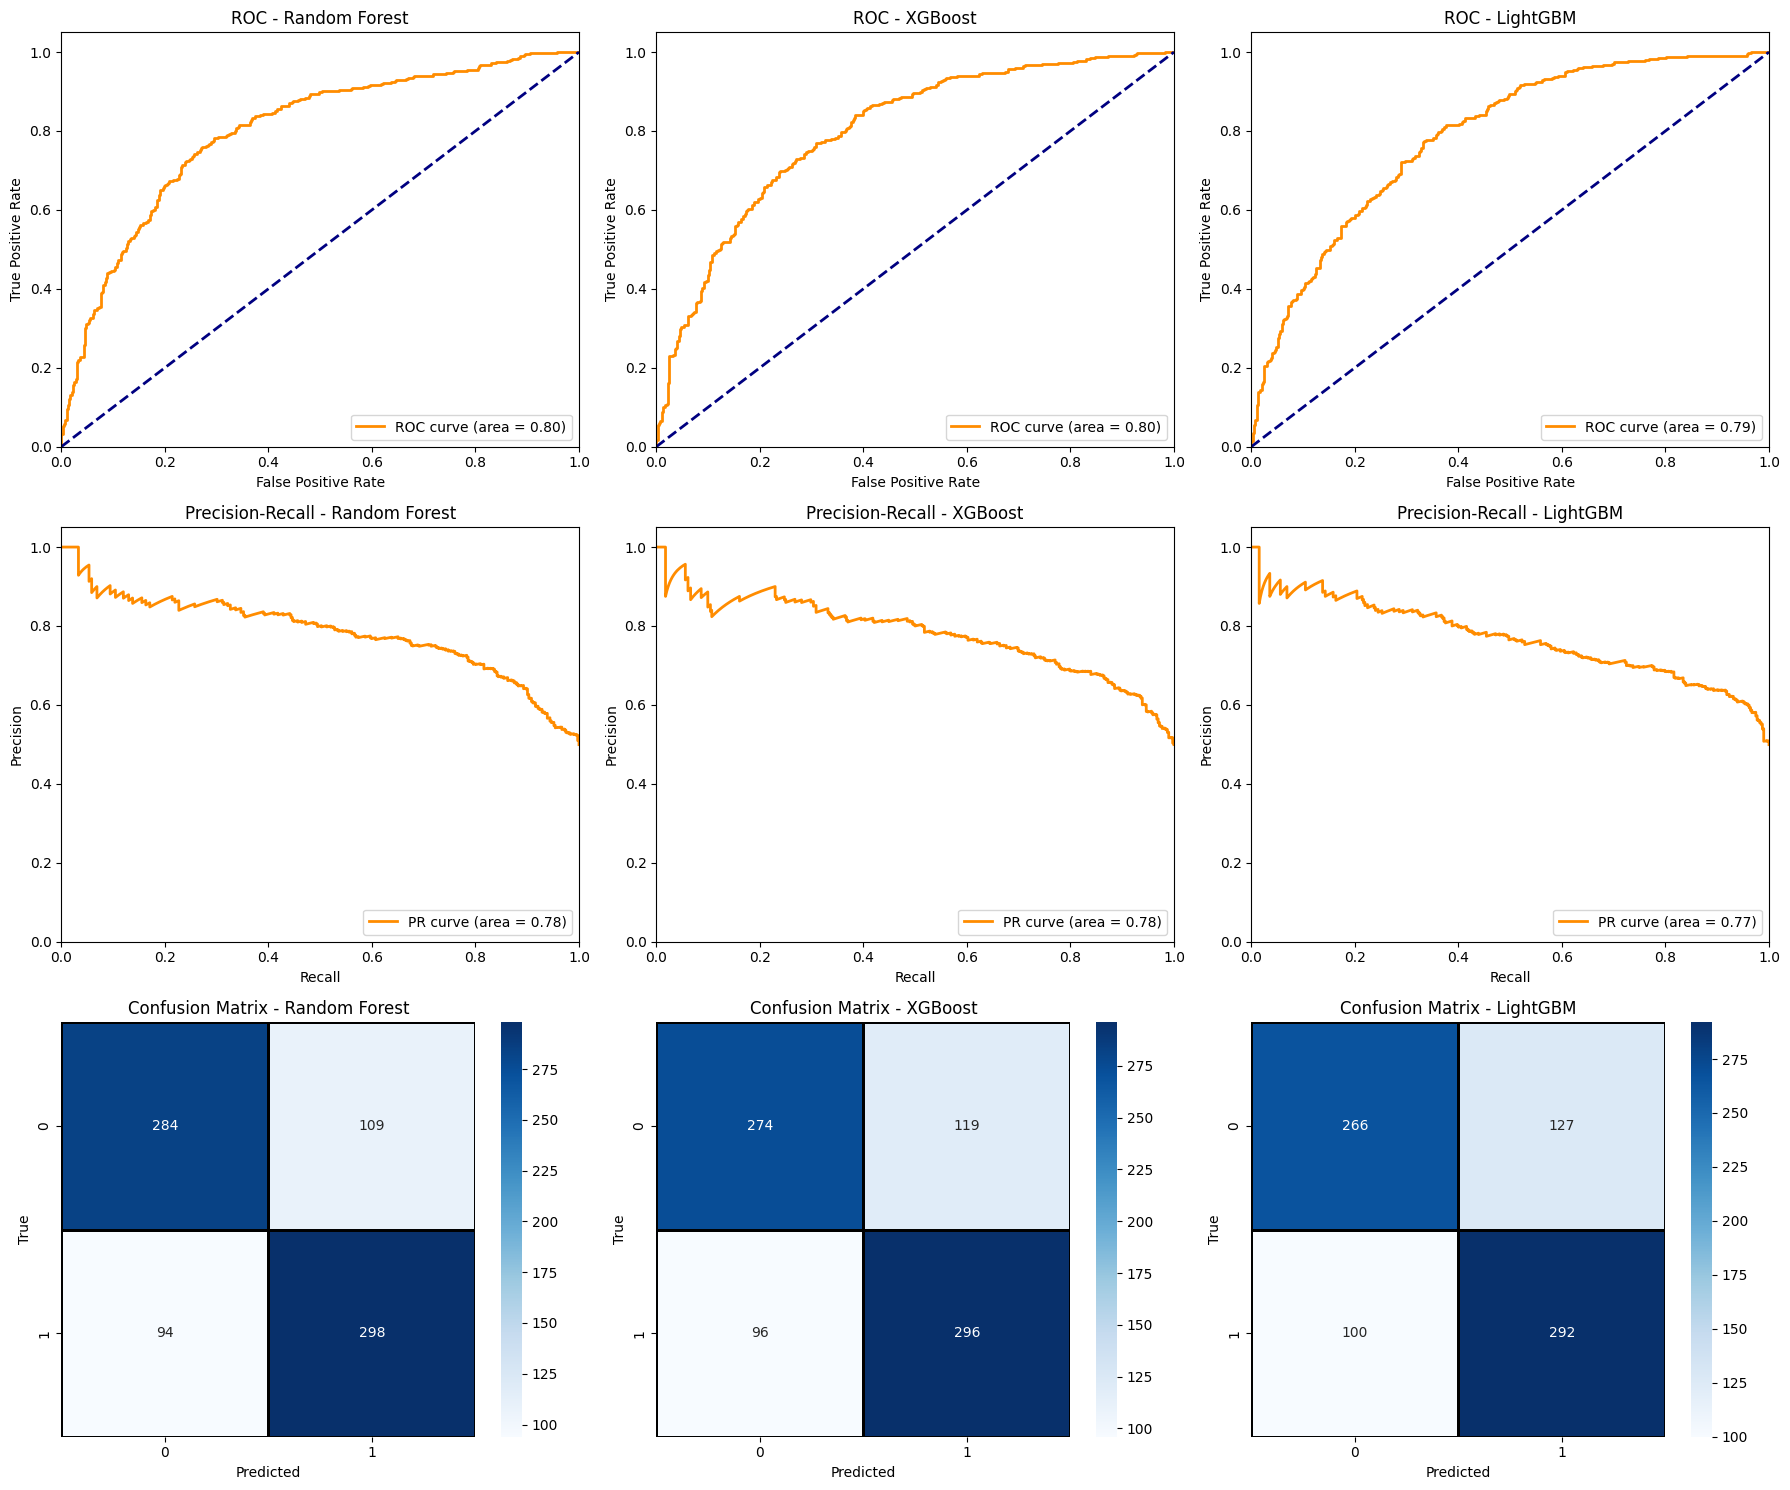

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7414012738853503, 'Precision': 0.7321867321867321, 'Recall': 0.7602040816326531, 'F1 Score': 0.7459324155193993, 'ROC AUC': 0.7980929012826505}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7261146496815286, 'Precision': 0.7132530120481928, 'Recall': 0.7551020408163265, 'F1 Score': 0.7335811648079307, 'ROC AUC': 0.7994690242509217}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.710828025477707, 'Precision': 0.6968973747016707, 'Recall': 0.7448979591836735, 'F1 Score': 0.7200986436498151, 'ROC AUC': 0.7871553201433243}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.710828025477707,
 'Precision': 0.6968973747016707,
 'Recall': 0.7448979591836735,
 'F1 Score': 0.7200986436498151,
 'ROC AUC': 0.7871553201433243}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7414


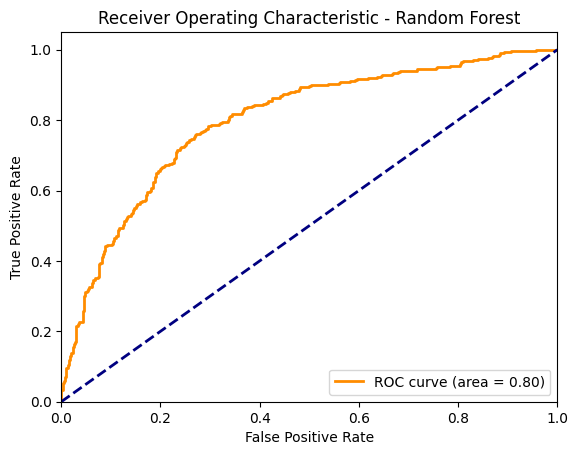

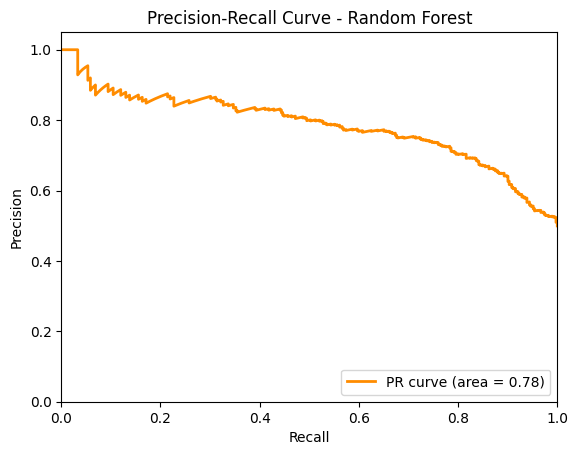

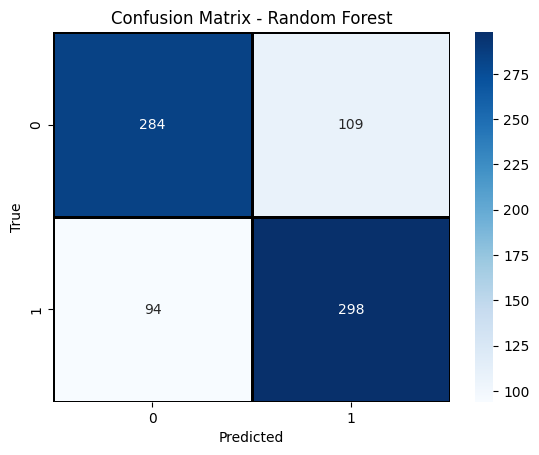

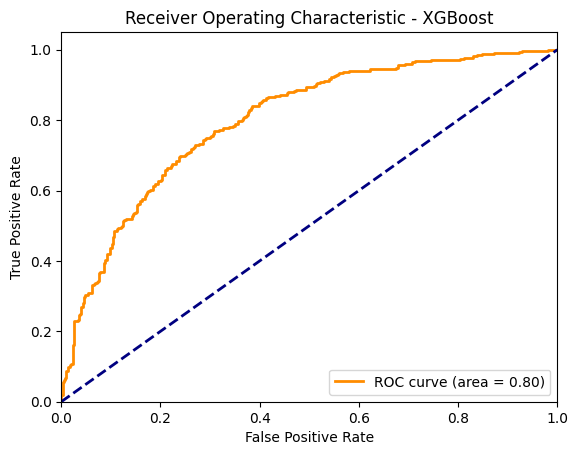

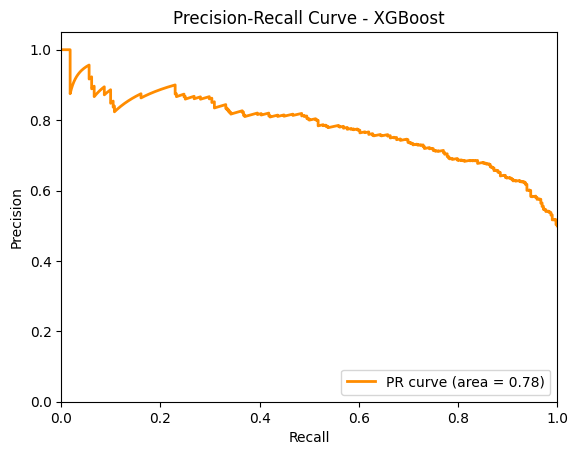

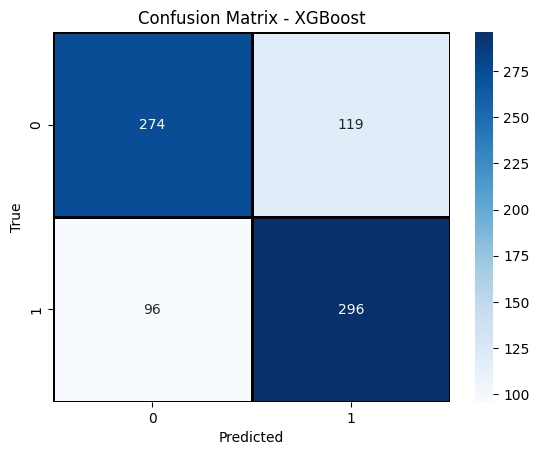

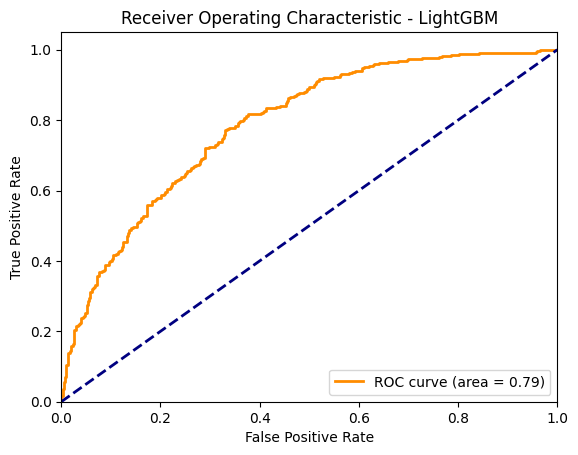

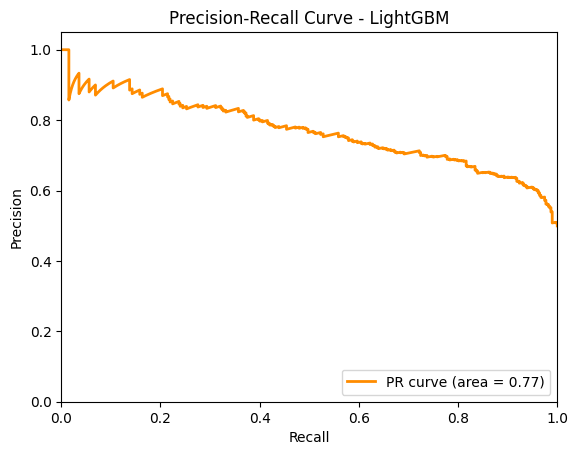

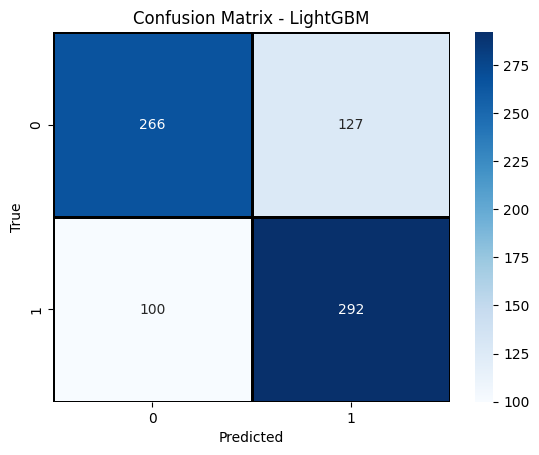

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

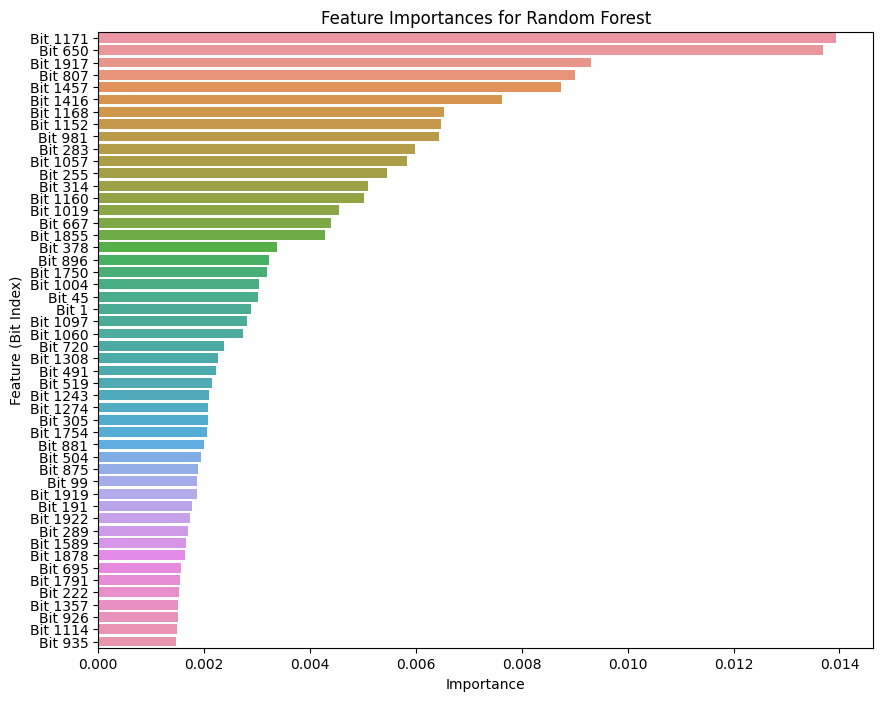

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
